In [25]:
import numpy as np
import json
from typing import List
import math
import os, os.path
from collections import defaultdict
import matplotlib.pyplot as plt

Got a dataset from Slay The Spire official discord where Baalor posted data about around 700 of his runs in 2022.

### Can we deterministically say what's the state of the deck at any floor?


In [4]:
data = json.load(open("C:/Users/lgerretsen/perso/perso/sts/2019-05-31-00-53#1028.json", "r"))


In [14]:
sample = data[0]
assert set(sample.keys()) == {'event'}
sample = sample["event"]
sample.keys()

dict_keys(['gold_per_floor', 'floor_reached', 'playtime', 'items_purged', 'score', 'play_id', 'local_time', 'is_ascension_mode', 'campfire_choices', 'neow_cost', 'seed_source_timestamp', 'circlet_count', 'master_deck', 'relics', 'potions_floor_usage', 'damage_taken', 'seed_played', 'potions_obtained', 'is_trial', 'path_per_floor', 'character_chosen', 'items_purchased', 'campfire_rested', 'item_purchase_floors', 'current_hp_per_floor', 'gold', 'neow_bonus', 'is_prod', 'is_daily', 'chose_seed', 'campfire_upgraded', 'win_rate', 'timestamp', 'path_taken', 'build_version', 'purchased_purges', 'victory', 'max_hp_per_floor', 'card_choices', 'player_experience', 'relics_obtained', 'event_choices', 'is_beta', 'boss_relics', 'items_purged_floors', 'is_endless', 'potions_floor_spawned', 'killed_by', 'ascension_level'])

In [15]:
sample["neow_bonus"]

'REMOVE_TWO'

In [16]:
sample["items_purged_floors"]


[7]

In [24]:
idx = 0
while 1:
    sample = data[idx]["event"]
    if sample["victory"]:
        break
    idx += 1
json.dump(sample, open("./example_vanilla.run", "w"), indent=4)

,Unnamed: 0,epoch,training_loss,training_L_inf,training_L_1,val_loss,val_L_inf,val_L_1
0,0,0.0,1.689723,0.644531,0.214030,1.858121,0.647949,0.211135
1,1,1.0,1.801943,0.625000,0.202148,1.645212,0.624023,0.206114
2,2,2.0,1.613895,0.585938,0.191732,NaN,NaN,NaN
3,3,3.0,1.719280,0.636719,0.224522,NaN,NaN,NaN
4,4,4.0,1.600421,0.613281,0.206163,NaN,NaN,NaN


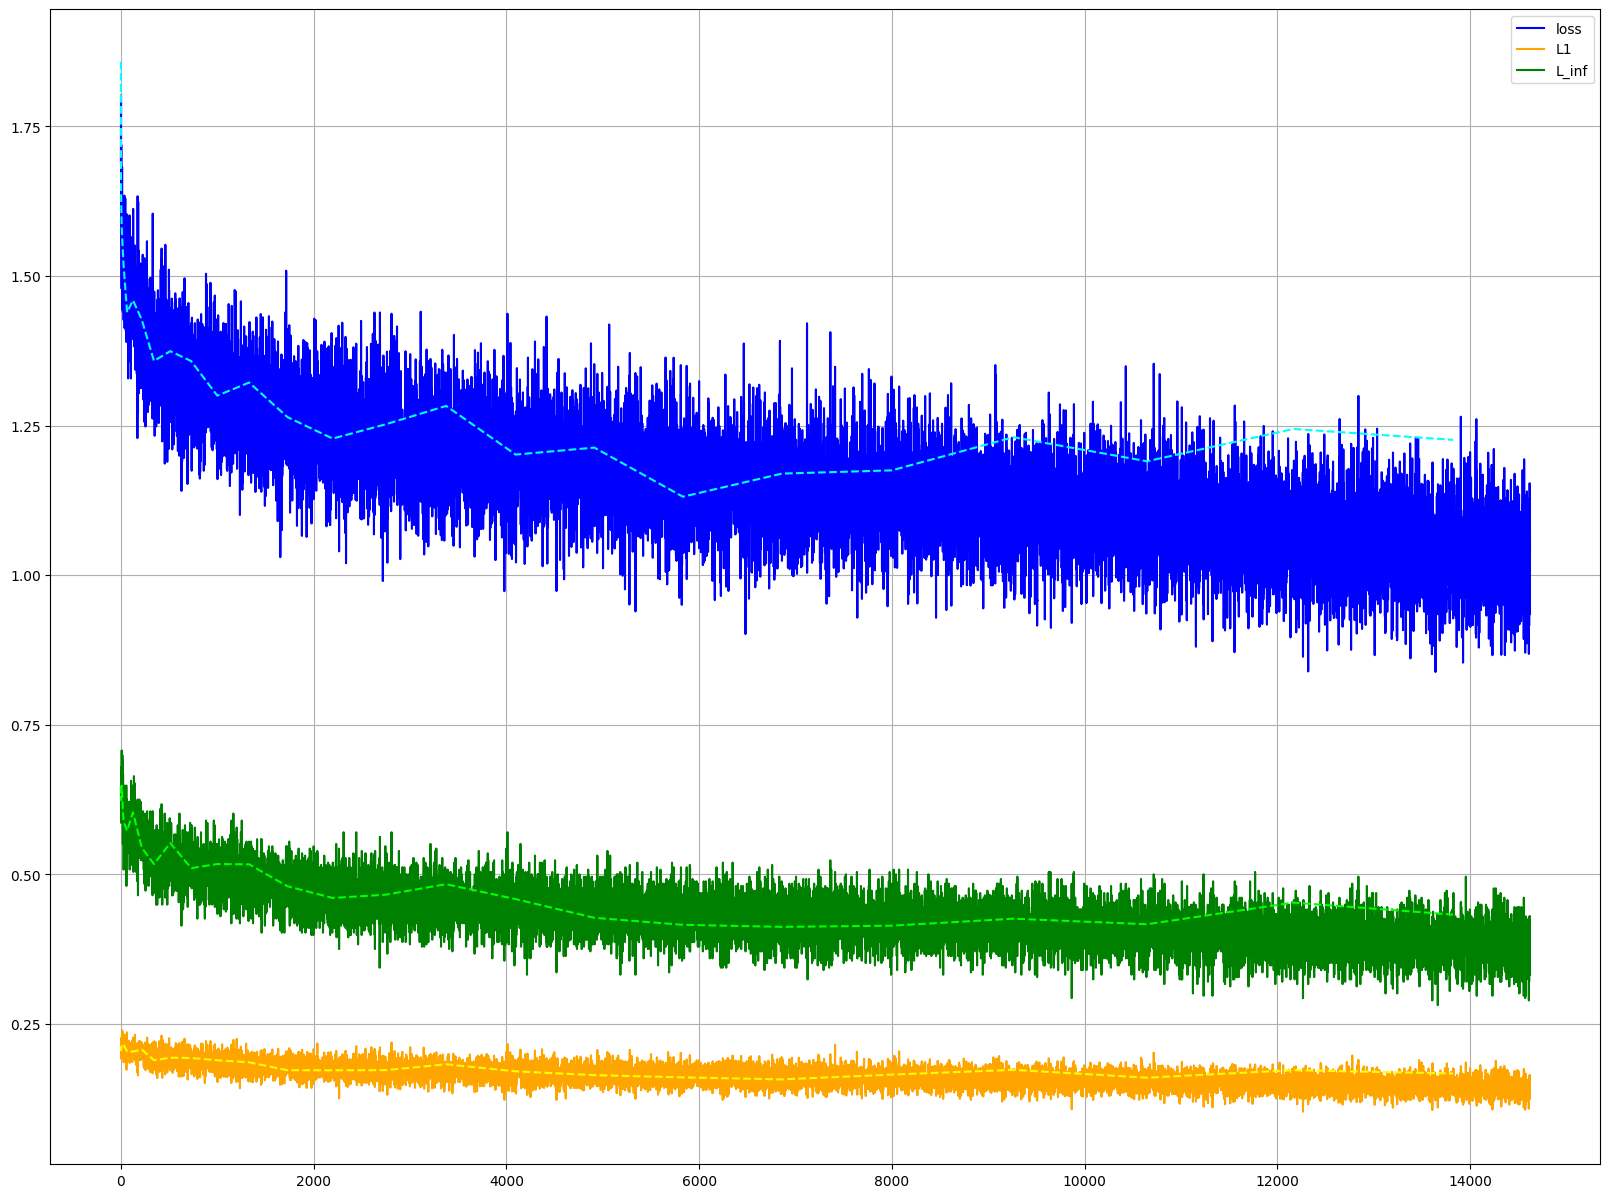

In [78]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import time

training_dirname = ""
training_dirname = "2023-01-14-15-47-15_blocks4-256_split0.8"
# training_dirname = "2023-01-07-20-10-29_blocks4-256_split0.8"
# training_dirname = "2023-01-06-20-25-13_21400_blocks4-256_split0.8"
# training_dirname = "2023-01-01-14-41-22_november_blocks4-256_split0.8"
# training_dirname = "2023-01-01-14-13-45_november_blocks4-256_split0.2"
# training_dirname = "2023-01-01-14-10-46_november_blocks4-128_split0.001"
# training_dirname = "2022-12-23-21-39-39_november_blocks8"
# training_dirname = "2022-12-21-22-51-42_november"

plt.figure(figsize=(20,15))

while 1:
    df = pd.read_csv(f"trainings/{training_dirname}/metrics.csv")

    plt.cla()
    plt.grid()

    epochs = df.epoch
    plt.plot(epochs, list(df.training_loss), color="blue", label="loss")
    plt.plot(epochs, list(df.training_L_1), color="orange", label="L1")
    plt.plot(epochs, list(df.training_L_inf), color="green", label="L_inf")

    def plot_holed_values(epochs, values, color, linestyle):
        xs = [x for x,val in zip(epochs, values) if not math.isnan(val)]
        ys = [val for x,val in zip(epochs, values) if not math.isnan(val)]
        plt.plot(xs, ys, color=color, linestyle=linestyle)
    plot_holed_values(epochs, list(df.val_loss), color="cyan", linestyle='dashed')
    plot_holed_values(epochs, list(df.val_L_1), color="yellow", linestyle='dashed')
    plot_holed_values(epochs, list(df.val_L_inf), color="lime", linestyle='dashed')
    plt.legend()
    # plt.pause(1.)

    break

df.head()



In [1]:
import re
import pandas as pd
import numpy as np
from glob import glob
import os, os.path
import json
import torch

from sts_ml.train import Model, pad_samples, TRAINING_DIR, PARAMS_FILENAME
from sts_ml.infer import count_parameters, TRAINING_DIR, PARAMS_FILENAME, pad_samples

training_dirname = ""
training_dirname = "2023-01-14-15-47-15_blocks4-256_split0.8"
# training_dirname = "2023-01-14-15-31-48_blocks1-256_split0.8"
# training_dirname = "2023-01-14-15-23-42_blocks1-256_split0.8"
# training_dirname = "2023-01-14-14-58-28_blocks1-256_split0.8"
# training_dirname = "2023-01-14-12-26-24_blocks4-256_split0.8"
# training_dirname = "2023-01-06-23-41-35_21400_blocks4-256_split0.8"
# training_dirname = "2023-01-06-20-25-13_21400_blocks4-256_split0.8"

training_dir = os.path.join(".", TRAINING_DIR, training_dirname)
params = json.load(open(os.path.join(training_dir, PARAMS_FILENAME), "r"))

# dataset = json.load(open("./SlayTheData_win_a20_ic_21400.data", "r"))
dataset = json.load(open(params["train"]["dataset"], "r"))
dataset = pad_samples(dataset)

split = params["train"]["split"]
train_val_split = int(split * len(dataset))
train_dataset = dataset[:train_val_split]
val_dataset = dataset[train_val_split:]



In [2]:
# training_dirname = ""
# training_dirname = "2023-01-14-15-31-48_blocks1-256_split0.8"
# training_dirname = "2023-01-14-15-23-42_blocks1-256_split0.8"
# training_dirname = "2023-01-14-15-04-01_blocks1-256_split0.8"
# training_dirname = "2023-01-14-14-58-28_blocks1-256_split0.8"
# training_dirname = "2023-01-14-12-26-24_blocks4-256_split0.8"
# training_dirname = "2023-01-06-23-41-35_21400_blocks4-256_split0.8"
# training_dirname = "2023-01-06-20-25-13_21400_blocks4-256_split0.8"

# training_dir = os.path.join(".", TRAINING_DIR, training_dirname)

batch_size = int(2**8)
model = Model(params)

ckpt_filename = os.path.join(training_dir, "4913.ckpt")
ckpt = 0

state_dict = torch.load(ckpt_filename)
assert count_parameters(list(model.parameters())) == count_parameters(list(state_dict.values())), (count_parameters(list(model.parameters())), count_parameters(list(state_dict.values())))
model.load_state_dict(state_dict)
model.eval()


Model(
  (embedding): Embedding(375, 256)
  (blocks): Sequential(
    (0): MHALayer(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff1): Linear(in_features=256, out_features=512, bias=True)
      (relu): ReLU()
      (ff2): Linear(in_features=512, out_features=256, bias=True)
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (1): MHALayer(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff1): Linear(in_features=256, out_features=512, bias=True)
      (relu): ReLU()
      (ff2): Linear(in_features=512, out_features=256, bias=True)
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (2): MHALayer(
      (att): 

In [10]:
for p, key, q in zip(list(model.parameters()), list(state_dict.keys()), list(state_dict.values())):
    if p.shape != q.shape:
        assert False, (key, p.shape,q.shape)

AssertionError: ('embedding.weight', torch.Size([375, 256]), torch.Size([366, 256]))

In [3]:
# logits, cross_ent_loss, l_inf, l_1 = model.predict_samples(train_dataset[:batch_size])
# print(logits, cross_ent_loss, l_inf, l_1)

# logits, cross_ent_loss, l_inf, l_1 = model.predict_samples(val_dataset[:batch_size])
# print(logits[:10,-10:,0])

sample = val_dataset[5]
model.predict(sample)


            cards expert_scores predicted_scores
0      defend_r+1          deck             deck
1      defend_r+1          deck             deck
2      defend_r+1          deck             deck
3      defend_r+1          deck             deck
4      strike_r+1          deck             deck
5      strike_r+1          deck             deck
6      strike_r+1          deck             deck
7      strike_r+1          deck             deck
8          bash+1          deck             deck
9   ascendersbane          deck             deck
10       disarm+1          deck             deck
11    fiendfire+1          deck             deck
12      armaments          deck             deck
13        havoc+1          deck             deck
14         exhume          deck             deck
15     shrugitoff          deck             deck
16       truegrit          deck             deck
17       offering          deck             deck
18       truegrit          deck             deck
19     intimidate   

In [44]:
import copy
import pandas as pd
from sts_ml.train import unpad
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)


def attn_weights_to_df(attn_weights, sample):
    sample = unpad(sample)
    deck_n = len(sample["deck"])
    cards_picked_n = len(sample["cards_picked"])
    cards_skipped_n = len(sample["cards_skipped"])

    assert len(attn_weights.shape) == 2
    tokens = sample["deck"] + sample["cards_picked"] + sample["cards_skipped"]
    attn_weights = attn_weights[-len(tokens):,-len(tokens):]
    df = pd.DataFrame(attn_weights)
    df = df.rename(columns=lambda idx: f"{idx} {tokens[idx]}", index=lambda idx: f"{idx} {tokens[idx]}")
    
    styler = df
    styler = styler.style.background_gradient(cmap=cm)
    styler = styler.format(precision=3)
    
    return styler

for block in model.blocks:
    attn_weights = block.attn_weights.detach().cpu().numpy()
    df = attn_weights_to_df(attn_weights[0], sample)

df

,0 defend_r+1,1 defend_r+1,2 defend_r+1,3 defend_r+1,4 strike_r+1,5 strike_r+1,6 strike_r+1,7 strike_r+1,8 bash+1,9 ascendersbane,10 disarm+1,11 fiendfire+1,12 armaments,13 havoc+1,14 exhume,15 shrugitoff,16 truegrit,17 offering,18 truegrit,19 intimidate,20 corruption+1,21 flamebarrier,22 sentinel,23 seeingred,24 warcry,25 twinstrike,26 headbutt+1
0 defend_r+1,0.016,0.016,0.016,0.016,0.012,0.012,0.012,0.012,0.014,0.006,0.026,0.022,0.030,0.015,0.016,0.011,0.019,0.032,0.019,0.014,0.026,0.019,0.021,0.009,0.034,0.038,0.042
1 defend_r+1,0.016,0.016,0.016,0.016,0.012,0.012,0.012,0.012,0.014,0.006,0.026,0.022,0.030,0.015,0.016,0.011,0.019,0.032,0.019,0.014,0.026,0.019,0.021,0.009,0.034,0.038,0.042
2 defend_r+1,0.016,0.016,0.016,0.016,0.012,0.012,0.012,0.012,0.014,0.006,0.026,0.022,0.030,0.015,0.016,0.011,0.019,0.032,0.019,0.014,0.026,0.019,0.021,0.009,0.034,0.038,0.042
3 defend_r+1,0.016,0.016,0.016,0.016,0.012,0.012,0.012,0.012,0.014,0.006,0.026,0.022,0.030,0.015,0.016,0.011,0.019,0.032,0.019,0.014,0.026,0.019,0.021,0.009,0.034,0.038,0.042
4 strike_r+1,0.007,0.007,0.007,0.007,0.020,0.020,0.020,0.020,0.015,0.009,0.020,0.038,0.021,0.026,0.015,0.013,0.025,0.032,0.025,0.022,0.015,0.017,0.022,0.021,0.074,0.067,0.068
5 strike_r+1,0.007,0.007,0.007,0.007,0.020,0.020,0.020,0.020,0.015,0.009,0.020,0.038,0.021,0.026,0.015,0.013,0.025,0.032,0.025,0.022,0.015,0.017,0.022,0.021,0.074,0.067,0.068
6 strike_r+1,0.007,0.007,0.007,0.007,0.020,0.020,0.020,0.020,0.015,0.009,0.020,0.038,0.021,0.026,0.015,0.013,0.025,0.032,0.025,0.022,0.015,0.017,0.022,0.021,0.074,0.067,0.068
7 strike_r+1,0.007,0.007,0.007,0.007,0.020,0.020,0.020,0.020,0.015,0.009,0.020,0.038,0.021,0.026,0.015,0.013,0.025,0.032,0.025,0.022,0.015,0.017,0.022,0.021,0.074,0.067,0.068
8 bash+1,0.016,0.016,0.016,0.016,0.012,0.012,0.012,0.012,0.011,0.012,0.016,0.028,0.030,0.017,0.019,0.017,0.018,0.022,0.018,0.012,0.013,0.020,0.015,0.015,0.034,0.029,0.023
9 ascendersbane,0.017,0.017,0.017,0.017,0.018,0.018,0.018,0.018,0.021,0.012,0.036,0.024,0.027,0.033,0.017,0.014,0.022,0.015,0.022,0.028,0.017,0.017,0.031,0.017,0.054,0.045,0.079


In [47]:
attn_weights.sum(axis=2)

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.99999994,
        0.99999994, 0.99999994, 0.99999994, 1.  

In [48]:
t = np.ones((2,2))
t[0,1] = 0
df = pd.DataFrame(t)
df["a"] = ["b", "c"]

df = df.style.background_gradient(cmap=cm)
df


,0,1,a
0,1.000000,0.000000,b
1,1.000000,1.000000,c


In [39]:
import copy
sample = copy.deepcopy(val_dataset[5])
sample['deck'] = sample['deck'][-24:]

In [77]:
from sts_ml.train import pad_sample
sample = {
    'deck': [
        'strike_r',
        'strike_r',
        'strike_r',
        'strike_r',
        'strike_r',
        'defend_r',
        'defend_r',
        'defend_r',
        'defend_r',
        'bash+1',
        'whirlwind+1',
        'darkshackles+1',
        'hemokinesis+1',
        'reaper',
        'anger',
        'fiendfire',
        'battletrance',
        'infernalblade',
        # 'apparition',
        # 'apparition',
        # 'apparition',
        'doubletap',
        'impervious',
        'shrugitoff',
    ],
    'cards_picked': [],
    'cards_skipped': [
        # 'clothesline',
        # 'flex',
        # 'perfectedstrike',
        # 'swordboomerang',
        # 'shrugitoff',
        # 'truegrit',
        # 'wildstrike',
        # 'twinstrike',
        # 'warcry',
        # 'ironwave',
        # 'headbutt',
        # 'clash',

        # 'whirlwind',
        # 'searingblow',
        # 'shockwave',
        # 'dualwield',
        # 'rampage',
        # 'recklesscharge',
        # 'metallicize',
        # 'infernalblade',
        # 'battletrance',
        # 'uppercut',
        # 'evolve',

        'reaper',
        # 'fiendfire',
        # 'demonform',
        # 'corruption',
        # 'doubletap',
        'impervious',
        'immolate',
    ],

}
sample = pad_sample(sample, len(val_dataset[0]))
model.predict(sample)


             cards expert_scores predicted_scores
0         strike_r          deck             deck
1         strike_r          deck             deck
2         strike_r          deck             deck
3         strike_r          deck             deck
4         strike_r          deck             deck
5         defend_r          deck             deck
6         defend_r          deck             deck
7         defend_r          deck             deck
8         defend_r          deck             deck
9           bash+1          deck             deck
10     whirlwind+1          deck             deck
11  darkshackles+1          deck             deck
12   hemokinesis+1          deck             deck
13          reaper          deck             deck
14           anger          deck             deck
15       fiendfire          deck             deck
16    battletrance          deck             deck
17   infernalblade          deck             deck
18       doubletap          deck             deck


In [6]:
from sts_ml.deck_history import card_to_n_upgrades
from sts_ml.train import token_to_index

samples = val_dataset[:1]

padded_samples = pad_samples(samples)
batched_idxes = []
deck_sizes = []
n_upgrades = []
for sample in padded_samples:
    tokens = sample["deck"] + sample["cards_picked"] + sample["cards_skipped"]
    idxes = [token_to_index(token) for token in tokens]
    batched_idxes.append(idxes)
    deck_sizes.append(len(sample["deck"]))
    n_upgrades.append([card_to_n_upgrades(token) for token in tokens])
batched_idxes = np.array(batched_idxes)
batched_idxes = torch.from_numpy(batched_idxes).to(model.device)
deck_sizes = np.array(deck_sizes)
n_upgrades = np.array(n_upgrades)
n_upgrades = torch.from_numpy(n_upgrades).to(model.device)

In [10]:
print(tokens)

['PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'PAD_TOKEN', 'defend_r+1', 'defend_r+1', 'defend_r+1', 'defend_r+1', 'strike_r+1', 'strik

In [15]:
token_to_index(ALL_TOKENS[2])

2

In [12]:
batched_idxes

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0, 351, 351, 351, 351, 239, 239, 239, 239, 124, 348, 144, 105, 312,
          87, 157, 218, 253, 221, 253,  35, 112]], device='cuda:0',
       dtype=torch.int32)

In [17]:
ALL_TOKENS[1]

'eviscerate'

In [2]:
from sts_ml.train import ALL_TOKENS
ALL_TOKENS.index('defend_r')

145

In [5]:
len(ALL_TOKENS)

457